# 4.1 선형 회귀

In [1]:
import numpy as np
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

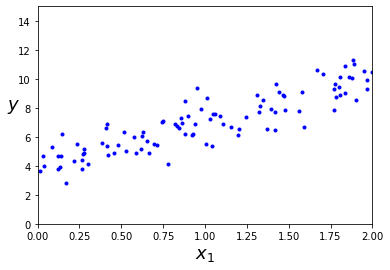

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

세타 계산

In [3]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.99328792],
       [3.0340945 ]])

예측

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.99328792],
       [10.06147691]])

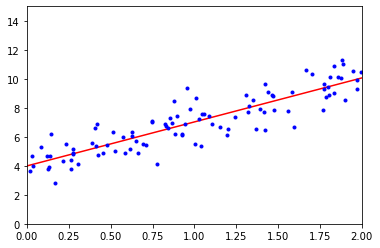

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

사이킷런에서 선형회귀 수행

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [7]:
lin_reg.intercept_,lin_reg.coef_

(array([3.99328792]), array([[3.0340945]]))

In [8]:
lin_reg.predict(X_new)

array([[ 3.99328792],
       [10.06147691]])

In [9]:
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[3.99328792],
       [3.0340945 ]])

유사역행열 직접 계산

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[3.99328792],
       [3.0340945 ]])

# 4.2 경사하강법

In [11]:
eta = 0.1
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta * gradients

In [12]:
theta

array([[3.99328792],
       [3.0340945 ]])

In [13]:
X_new_b.dot(theta)

array([[ 3.99328792],
       [10.06147691]])

In [14]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X,y,"b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration >0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0,2,0,15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

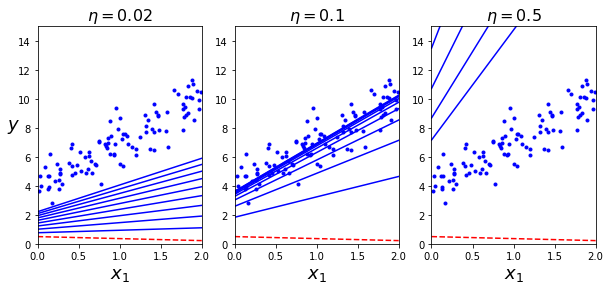

In [15]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

## 4.2.2 확률적 경사하강법
- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레디언트를 계산 >> 훨씬 빠름, 매우 큰 훈련세트도 훈련가능
- 불안정하다    
   
딜레마 : local minimum을 벗어날 순 있지만 global minimum에 도달하지 못할 수 있음   
 -> 시작할 때는 learning rate를 크게하고 점친적으로 줄여나감. 매 반복에서 learning rate를 결정하는 함수를 learning schedule이라 한다 

In [16]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

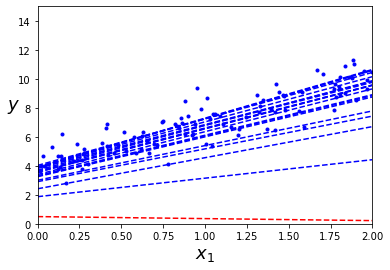

In [17]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)
theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b--" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)- yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [18]:
theta

array([[3.99385653],
       [2.98856239]])

In [19]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=5,penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, max_iter=5, penalty=None, random_state=42)

In [20]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.94988523]), array([3.21924885]))

## 4.2.3 미니배치 경사하강법

In [21]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [22]:
theta

array([[4.07831663],
       [3.12987872]])

In [23]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

In [24]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="SGD")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="minibatch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
#save_fig("gradient_descent_paths_plot")
plt.show()

NameError: name 'save_fig' is not defined

# 4.3 다향회귀
선형모델이 아닌 2차방정식 이상

In [47]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [48]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X +2 + np.random.randn(m,1)

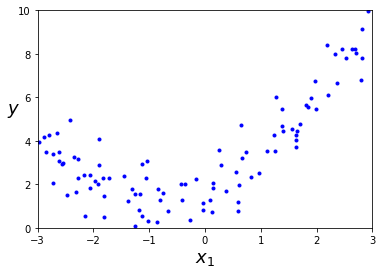

In [49]:
plt.plot(X,y,"b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3,3,0,10])
plt.show()

In [50]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [51]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [52]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

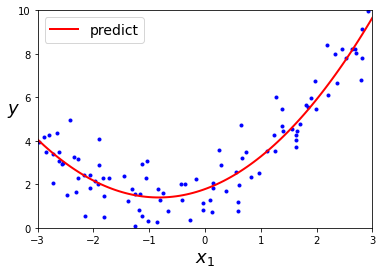

In [53]:

X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="predict")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
#save_fig("quadratic_predictions_plot")
plt.show()

# 4.4 학습곡선
- 300차 다향회귀모델은 과대적합
- 선형모델은 과소적합   



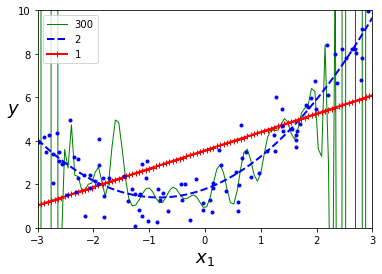

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2,1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg)
    ])
    polynomial_regression.fit(X,y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new,y_newbig,style,label=str(degree), linewidth=width)
plt.plot(X,y,"b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3,3,0,10])
plt.show()

모델이 과소적합되었는지 과대적합되었는지 어떻게 판단할 것인가?  

1. 교차검증(cross validation)
2. 학습곡선 : 훈련세트에서 크기가 다른 서브세트를 만들어 모델으 여러번 훈련

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, random_state=10)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation")
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel("training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

과소적합의 경우(선형 모델)

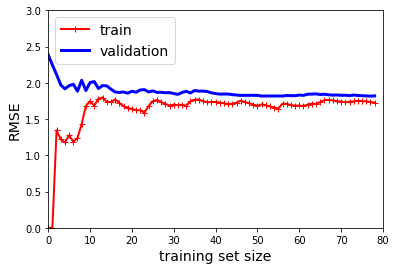

In [56]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X,y)
plt.axis([0,80,0,3])
plt.show()

과대적합의 경우(10차 다항방정식)

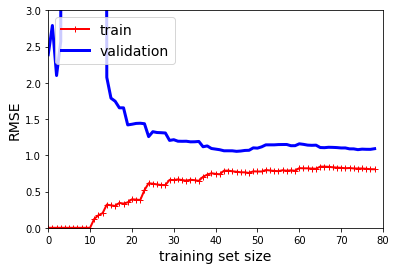

In [57]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression,X,y)
plt.axis([0,80,0,3])
plt.show()

- 훈련데이터의 오차가 선형모델의 경우보다 낮음
- 두 곡선사이의 공간 >> 훈련데이터에서의 모델성능이 검증데이터보다 훨씬 좋다 >> 과대적합모델의 특징

# 4.5 규제가 있는 선형모델
- 과대적합 감소 방법 >> 모델규제
- 선형모델에선 보통 모델의 가중치를 제한 >> 릿지, 라쏘, 엘라스틱넷

## 4.5.1 릿지 회귀
- 규제항을 비용함수에 추가. 규제는 테스트세트에서 성능을 평가하거나 실제 샘플 예측에는 포함되지 않는다

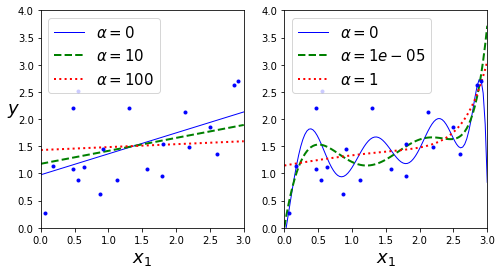

In [58]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

#save_fig("ridge_regression_plot")
plt.show()

In [59]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [60]:
sgd_reg = SGDRegressor(max_iter=50, penalty="l2", tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

In [61]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

### 4.5.2 라쏘회귀
- l2 노름 대신 l1노름
- 덜 중요한 특성의 가중치를 제거하려 함

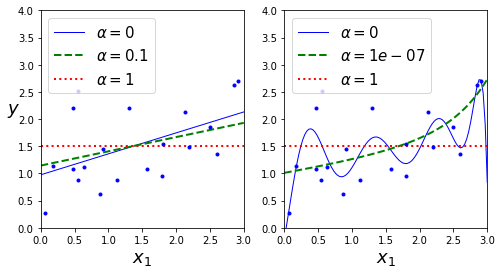

In [62]:
from sklearn.linear_model import Lasso
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0,0.1,1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0,10**-7,1), tol=1, random_state=42)

plt.show()

In [63]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## 4.5.3 엘라스틱넷
- 릿지와 라쏘 절충
- 특성 수가 훈련 샘플 수보다 많거나, 특성 몇개가 강하게 연관되어 있을떄는 엘라스틱넷을 선호

In [64]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=-.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.56513106])

## 4.5.4 조기종료
- 검증에러가 최솟값에 도달하면 훈련 중지

In [65]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m,1)-3
y = 2 + X + 0.5* X ** 2 + np.random.randn(m,1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5,random_state=10)

ploy_scaler = Pipeline([
    ("poly_feautres", PolynomialFeatures(degree=90,include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = ploy_scaler.fit_transform(X_train)
X_val_poly_scaled = ploy_scaler.transform(X_val)

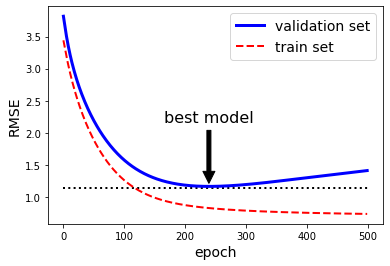

In [66]:
sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)
n_epochs = 500
train_errors,val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train,y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate("best model",
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse+1),
             ha="center",
             arrowprops=dict(facecolor="black", shrink=0.05),
             fontsize=16)

best_val_rmse -= 0.03
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
#save_fig("early_stopping_plot")
plt.show()

In [67]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)

    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [68]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, warm_start=True))

In [69]:
t1a, t1b, t2a, t2b = -1,3,-1.5,1.5

t1s = np.linspace(t1a,t1b,500)
t2s = np.linspace(t2a,t2b, 500)
t1,t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1,1], [-0.3,-1],[1,0.1]])
yr = 2 * Xr[:,:1] + 0.5 * Xr[:,1:]
J = (1/len(Xr) * np.sum((T.dot(Xr.T)-yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T,ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

# 4.6 로지스틱회귀
4.6 로지스틱회귀
- 샘플이 특정 클래스에 속할 확률을 추정하는데 널리 사용됨. 추정확률이 50%가 넘으면 그 샘플이 해당 클래스에 속한다고 예측

## 4.6.1 확률 추정
- 가중치 합을 계산한후, 그 합의 로지스틱을 출력(이떄 로지스틱은 시그모이드 함수)

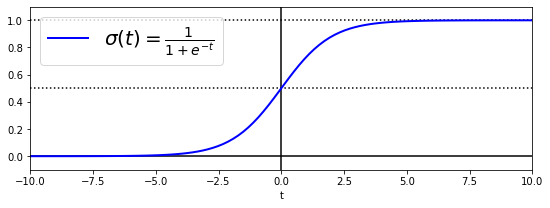

In [72]:

t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
# save_fig("logistic_function_plot")
plt.show()

## 4.6.3 결정 경계

In [26]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [32]:
X = iris["data"][:,3:]
y = (iris["target"]==2).astype(np.int)

In [34]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X,y)

LogisticRegression(random_state=42, solver='liblinear')

- loss function으로 log-loss

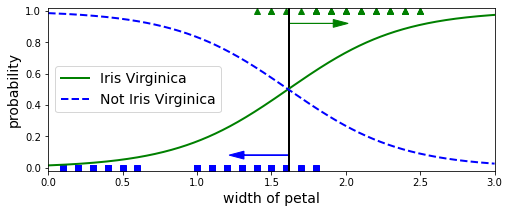

In [52]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_prob = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_prob[:,1]>=0.5][0]

plt.figure(figsize=(8,3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary,decision_boundary], [-1,2],"k-", linewidth=2)
plt.plot(X_new, y_prob[:,1], "g-", linewidth=2, label="Iris Virginica")
plt.plot(X_new, y_prob[:,0], "b--", linewidth=2, label="Not Iris Virginica")
plt.arrow(decision_boundary, 0.08,-0.3,0, head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(decision_boundary, 0.92,0.3,0, head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.xlabel("width of petal", fontsize=14)
plt.ylabel("probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0,3,-0.02,1.02])
plt.show()

In [44]:
y_prob # column 0은 Iris가 아닐 확률, column 1은 Iris가 맞을 확률

array([[0.98554411, 0.01445589],
       [0.98543168, 0.01456832],
       [0.98531838, 0.01468162],
       ...,
       [0.02618938, 0.97381062],
       [0.02598963, 0.97401037],
       [0.02579136, 0.97420864]])

In [53]:
decision_boundary

array([1.61561562])

In [59]:
log_reg.predict([[1.7],[1.5]]) # width가 1.7이면 1, 1.5면 0이라고 ㅇ


array([1, 0])

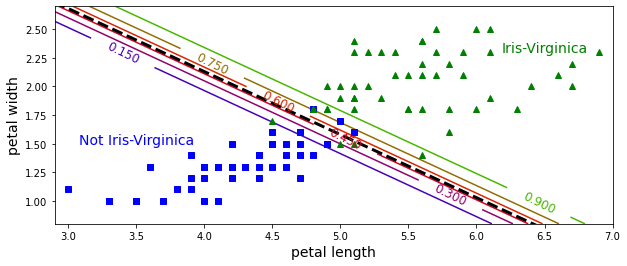

In [71]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver='liblinear', C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs") # label이 0인 것과 index가 같은 X의 원소 중에서 petal length(column 0), petal width(column 1)
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
#save_fig("logistic_regression_contour_plot")
plt.show()

## 4.6.4 소프트맥스 회귀
- loss function으로 cross-entropy사용

In [74]:
X = iris["data"][:,(2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [80]:
softmax_reg.predict([[5,2]])

array([2])

In [81]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

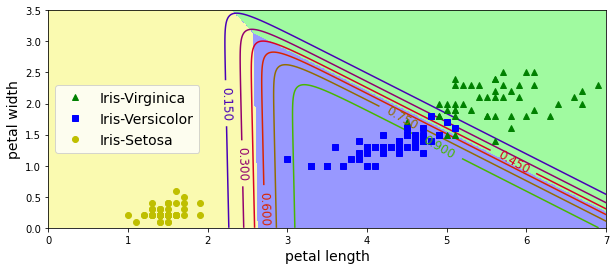

In [79]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("petal length", fontsize=14)
plt.ylabel("petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
# save_fig("softmax_regression_contour_plot")
plt.show()